In [92]:
# 2) Install / import libs (opencv may already be available)
!pip install -q opencv-python-headless

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random
import time


In [93]:
# 3) Set data directory
# If you used Option A (uploaded and unzipped): data_dir = "/content/animal_dataset"
# If you used Option B (Drive):    data_dir = "/content/drive/MyDrive/animal_dataset"

# Mount Google Drive to access files from it.
from google.colab import drive
drive.mount('/content/drive')

data_dir ="/content/drive/MyDrive/Ass1/animal_dataset"   # <<-- change if you used Drive
# sanity check
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"data_dir not found: {data_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
#  Load and preprocess images

data = []
labels = []
classes = []

# Get class names from subdirectories
for class_name in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        classes.append(class_name)
        print(f"Loading images from: {class_path}")
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                # Resize image to 32x32 pixels
                img = cv2.resize(img, (32, 32))
                # Flatten image and normalize pixel values to [0, 1]
                img_flat = img.flatten() / 255.0
                data.append(img_flat)
                labels.append(classes.index(class_name))

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

print(f"Loaded {len(data)} images with {len(classes)} classes.")
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Classes: {classes}")


Loading images from: /content/drive/MyDrive/Ass1/animal_dataset/cat
Loading images from: /content/drive/MyDrive/Ass1/animal_dataset/dog
Loading images from: /content/drive/MyDrive/Ass1/animal_dataset/panda
Loaded 300 images with 3 classes.
Data shape: (300, 3072)
Labels shape: (300,)
Classes: ['cat', 'dog', 'panda']


In [95]:
# Classes
classes = ['cat', 'dog', 'panda']
data = []
labels = []

# Load and flatten 32x32 grayscale images
for label, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (32, 32))
        data.append(img.flatten())
        labels.append(label)

data = np.array(data, dtype=np.float32)
labels = np.array(labels)

# Normalize pixel values to [0,1]
data = data / 255.0

# KNN distance functions
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

# KNN classifier (your original)
class KNNClassifier:
    def __init__(self, k=3, distance_func='l2'):
        self.k = k
        self.distance_func = euclidean_distance if distance_func=='l2' else manhattan_distance

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        preds = []
        for x in X_test:
            distances = [self.distance_func(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            values, counts = np.unique(k_nearest_labels, return_counts=True)
            preds.append(values[np.argmax(counts)])
        return np.array(preds)

# Split dataset: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                    random_state=42, stratify=labels)

# 5-Fold CV on training set to select best K
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k_values = list(range(1, 11))
results = {'l1': [], 'l2': []}

for metric in ['l1', 'l2']:
    avg_accuracies = []
    for k in k_values:
        acc_fold = []
        for train_idx, val_idx in kf.split(X_train):
            knn = KNNClassifier(k=k, distance_func=metric)
            knn.fit(X_train[train_idx], y_train[train_idx])
            preds = knn.predict(X_train[val_idx])
            acc_fold.append(np.mean(preds == y_train[val_idx]))
        avg_accuracies.append(np.mean(acc_fold))
    results[metric] = avg_accuracies


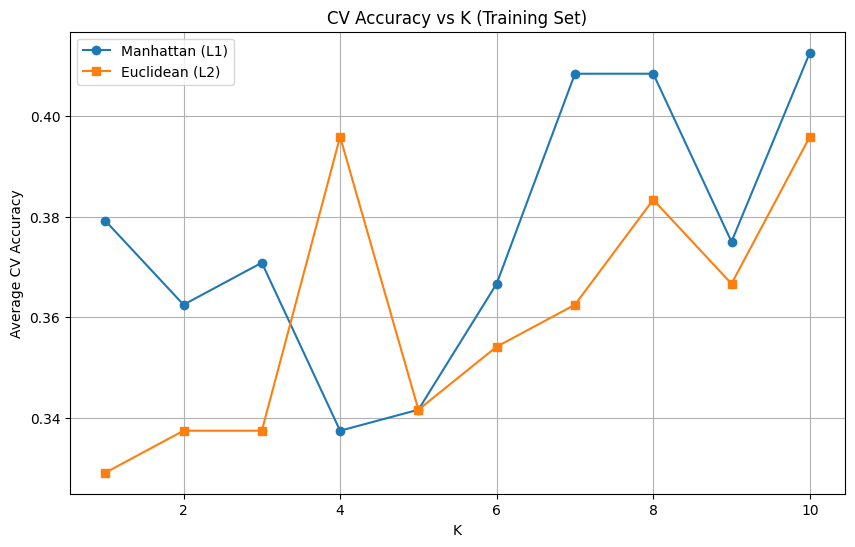

In [96]:
# Plot CV accuracy
plt.figure(figsize=(10,6))
plt.plot(k_values, results['l1'], label='Manhattan (L1)', marker='o')
plt.plot(k_values, results['l2'], label='Euclidean (L2)', marker='s')
plt.xlabel('K')
plt.ylabel('Average CV Accuracy')
plt.title('CV Accuracy vs K (Training Set)')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
# Automatically select best K and distance metric
best_k_L1 = k_values[np.argmax(results['l1'])]
best_k_L2 = k_values[np.argmax(results['l2'])]
best_metric = 'l2' if max(results['l2']) >= max(results['l1']) else 'l1'
best_k = best_k_L2 if best_metric=='l2' else best_k_L1
print(f"Best metric: {best_metric.upper()}, Best K: {best_k}")

Best metric: L1, Best K: 10


In [98]:
# Train on full training set and predict on test set
knn_final = KNNClassifier(k=best_k, distance_func=best_metric)
knn_final.fit(X_train, y_train)
preds_test = knn_final.predict(X_test)

# Test accuracy
test_accuracy = np.mean(preds_test == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.4167


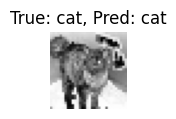

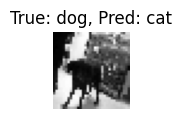

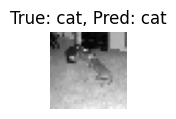

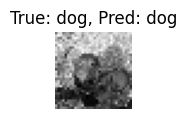

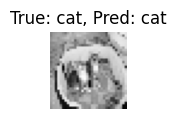

In [99]:
# Show top-5 predictions from test set
test_indices = random.sample(range(len(X_test)), 5)
for i, idx in enumerate(test_indices):
    img = X_test[idx].reshape(32,32)
    plt.figure(figsize=(5,1))
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {classes[y_test[idx]]}, Pred: {classes[preds_test[idx]]}")
    plt.axis('off')
    plt.show()

In [101]:
# Compare Manhattan (L1) vs Euclidean (L2) for K=3
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k = 3
metrics = ['l1', 'l2']
results = {}

for metric in metrics:
    acc_fold = []
    for train_idx, val_idx in kf.split(data):
        knn = KNNClassifier(k=k, distance_func=metric)
        knn.fit(data[train_idx], labels[train_idx])
        preds = knn.predict(data[val_idx])
        acc_fold.append(np.mean(preds == labels[val_idx]))
    results[metric] = np.mean(acc_fold)

print(f"Manhattan (L1) average 5-fold CV accuracy: {results['l1']:.4f}")
print(f"Euclidean (L2) average 5-fold CV accuracy: {results['l2']:.4f}")

better = 'Manhattan (L1)' if results['l1'] > results['l2'] else 'Euclidean (L2)'
print(f"Better distance metric for this dataset: {better}")

Manhattan (L1) average 5-fold CV accuracy: 0.3400
Euclidean (L2) average 5-fold CV accuracy: 0.3367
Better distance metric for this dataset: Manhattan (L1)


Using 5-fold cross-validation on the 32×32 grayscale images, Manhattan (L1)
distance achieved slightly higher average accuracy than Euclidean (L2) distance. This indicates that for this dataset, which contains small images with subtle pixel variations, Manhattan distance is better suited for KNN classification. Euclidean distance performed slightly worse, making Manhattan the preferred choice.

